1° Progetto Social Computing

Let's import the needed libraries, read the .csv file and set the SERP API key 

In [2]:
import pandas as pd
import networkx as nx
import pyvis as pv
import json
import numpy as np
from serpapi import GoogleScholarSearch
import pickle
import matplotlib.pyplot as plt

GoogleScholarSearch.SERP_API_KEY = 'my_key' #Denis SERP KEY
df = pd.read_csv("data\\nodes.csv")  #read nodes.csv

We are going to calculate the queries looking for the requested people, for each row in the dataframe.
We will save the queries into 'result' and the affiliations into 'aff'

In [23]:
search = []
result = []
aff = [] #save the affiliations from nodes.csv
name_authors = []
name_coauthors_per_author = [] #will be used later, for now we store the authors names
for index, row in df.iterrows():
    params = {"engine": "google_scholar_profiles", "hl": 'en', "mauthors": row['name']}
    search.append(GoogleScholarSearch(params))  #obtain the queries of all the authors
    result.append(search[index].get_dict()) #transform the json into a dictionary for each query
    aff.append(row['affiliations'])
    name_authors.append(row['name'])
    name_coauthors_per_author.append([row['name']])

Now we need to find, for every .json file we stored into 'results' (1°for loop), for each profile inside the analyzed json (2°for loop), the profile we were looking for (using the affiliation) and store all the information regarding the author_id, cited_by and the interests.

In [ ]:
author = []
cited = []
interests = []
for index_result, value_result in enumerate(result): #for each json I retrieve the data I need
    for value_profiles in result[index_result]['profiles']: #for each profile inside of a single json
        interests_per_person = [] #list of interests for every person; clean the list at every iteration
        if (value_profiles['affiliations']) == aff[index_result]: #if it's the profile im looking for, 
                                                                  #then save save author_id, cited_by & interests
            author.append(value_profiles['author_id'])
            cited.append(value_profiles['cited_by'])

            for i in value_profiles['interests']: #interests can be multiple for every person, so let's group them by person
                interests_per_person.append(i['title'])
            
            interests.append(interests_per_person)

Let's update the nodes.csv file with new columns with data retrieved from the queries

In [ ]:
df['author_id'] = author
df['cited_by'] = cited
df['interests'] = interests
df.to_csv("data\\nodes.csv", index = False)

Let's retrieve the list of the coauthors for each person in nodes.csv

In [ ]:
search = []
result = []
coauthors = []
for index, value in enumerate(author):
    params = {"engine": "google_scholar_author", "hl": 'en', "author_id": value} #searching with the author_id
    search.append(GoogleScholarSearch(params))
    result.append(search[index].get_dict())
    coauthors.append(result[index]['co_authors']) #list of coauthors for every author

For each of the 7 authors, we get into their profiles (via id) and download coauthors names, grouped by author 

In [ ]:
for index_author, value_author in enumerate(coauthors): #for each author
    coauthors_names = []
    for index_coauthor, value_coauthor in enumerate(coauthors[index_author]): #for each coauthor of the selected author
        coauthors_names.append(value_coauthor['name']) #save the name of the coauthor

    name_coauthors_per_author[index_author] = coauthors_names #list of coauthor grouped by authors
    

We use the names of the coauthors to look for researchers matching that name.

In [ ]:
search = []
result = []
for index, value in enumerate(name_coauthors_per_author): #for each coauthor list of an author
    for i, v in enumerate(value): #for each coauthor of a coauthor list
        params = {"engine": "google_scholar_profiles", "hl": 'en', "mauthors": v}
        search.append(GoogleScholarSearch(params))
        result.append(search[i].get_dict())

With the list of all the coauthors, we select for each coauthor the first result (with index 0) and take all the information requested.

In [ ]:
author = []
name = []
affiliations = []
cited = []
interests = []
for index_result, value_result in enumerate(result): #for each json I retrieve the data I need
        interests_per_person = [] #list of interests for every person; clean the list at every iteration
        
        author.append(value_result['profiles'][0]['author_id']) #take the first profile appearing on the query result
        name.append(value_result['profiles'][0]['name'])
        affiliations.append(value_result['profiles'][0]['affiliations'])
        cited.append(value_result['profiles'][0]['cited_by'])

        if('interests' in value_result['profiles'][0]): #check if the coauthor actually has any interests
            for i in value_result['profiles'][0]['interests']: #for every interests, put the name into a list
                interests_per_person.append(i['title'])
        
        interests.append(interests_per_person) #list ehere each item is a list of interests of the specific coauthor

We create a dataframe of coauthors through a dictionary

In [ ]:
data = {
    'name': name,
    'affiliations': affiliations,
    'author_id': author,
    'cited_by': cited,
    'interests': interests
}

df2 = pd.DataFrame(data)
df2 = df2.drop_duplicates(subset='author_id') #delete the duplicates

We concatenate authors and coauthors in the same dataframe

In [ ]:
df1 = pd.read_csv("data\\nodes.csv")
df = pd.concat([df1, df2])
df = df.drop_duplicates(subset='author_id')
df.to_csv("data\\nodes.csv", index = False) #overwrite nodes.csv with authors and coauthors combined

We create a new dataframe representing the edges between author-coauthor, both ways

In [ ]:
author1 = [] #1st column dataframe
author2 = [] #2nd column dataframe

for index_author, value in enumerate(name_coauthors_per_author): #for every author, analyze the coauthor list
    for coauthor in value: #for every coauthor in the coauthor list
        author1.append(name_authors[index_author])
        author2.append(coauthor)

data = {
    'author1': author1,
    'author2': author2
}
df3 = pd.DataFrame(data) #create a new dataframe for the edges
df3.to_csv("data\\edges.csv", index = False)

3. Utilizzando i due DataFrame prodotti:
a. Generare un grafo indiretto che ne rappresenta le informazioni contenute.
Salvare (serializzare) il grafo in locale nella cartella /graphs .
b. Visualizzare il grafo prodotto colorando i nodi a seconda del loro grado con le
seguenti colorazioni: grigio per nodi con grado uguale a 1, blu per nodi con
grado compreso tra 2 e 10, viola per nodi con grado compreso tra 11 e 20,
giallo per nodi con grado maggiore di 20. Inoltre, per ciascun nodo
visualizzare il nome dell’autore. Salvare la visualizzazione nella cartella
/visualizations

In [4]:
## 3.a
## Generazione grafo

nodes_df = pd.read_csv("data\\nodes.csv")
edges_df= pd.read_csv("data\\edges.csv")

coautorship_graph= nx.Graph()
coautorship_graph.add_nodes_from(nodes_df['name'])
coautorship_graph.add_edges_from(zip(edges_df['author1'], edges_df['author2'] ))

## Salvataggio grafo
with open('graphs\\coauthorship_graph.gpickle', 'wb') as file:
    pickle.dump(coautorship_graph, file)



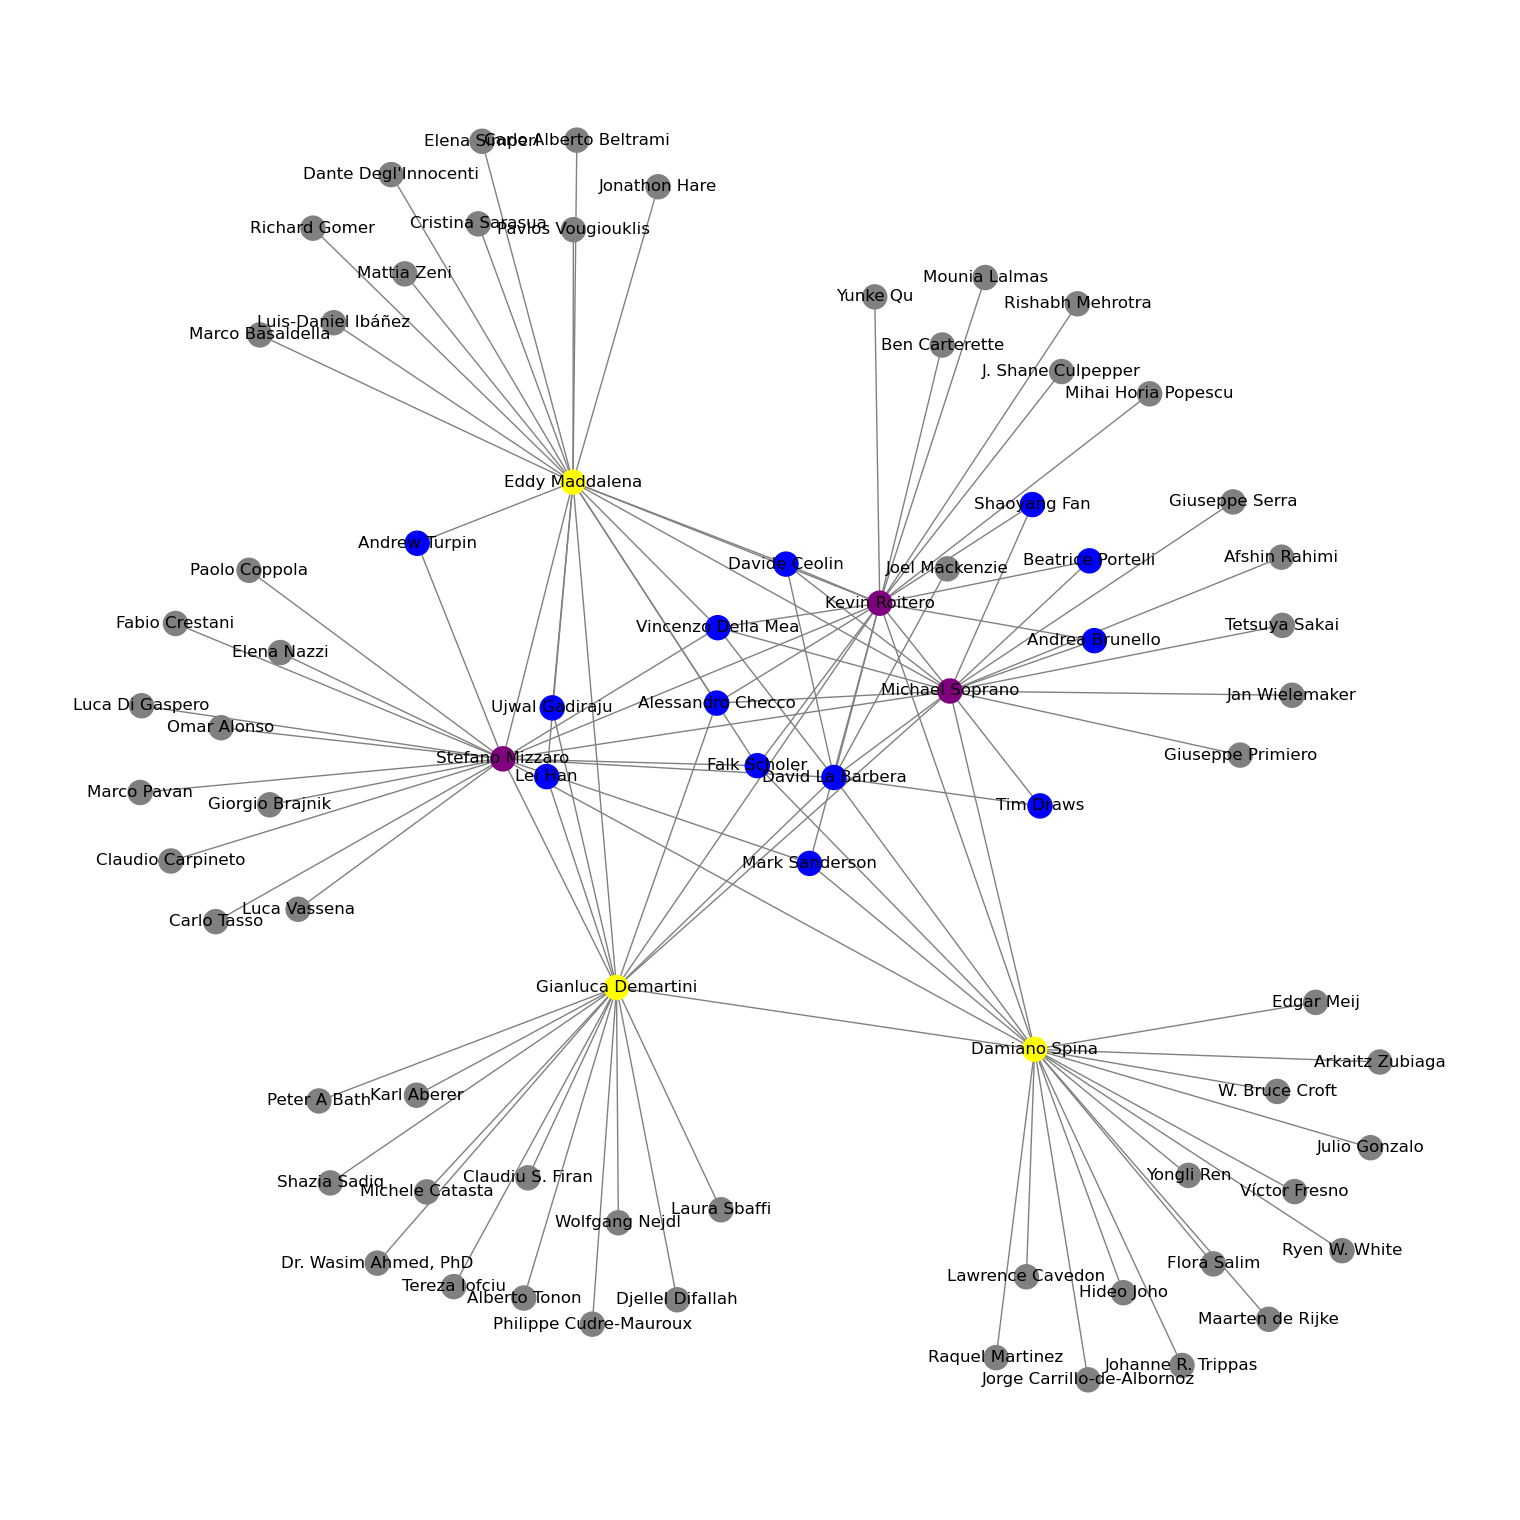

In [5]:
##3.b
## Visualizzare il grafo

## Logica per la gestione dei colori
def Choose_Node_Color(degree):
        if degree == 1:
                return 'gray'
        elif 2 <= degree <= 10:
                return 'blue'
        elif 11 <= degree <= 20:
                return 'purple'
        else:
                return 'yellow'
        

def Node_Color(Graph):
        return [Choose_Node_Color(Graph.degree[node]) for node in Graph.nodes()]
        
## print grafo
plt.figure(figsize=(15, 15))
nx.draw(coautorship_graph,
        pos=nx.spring_layout(coautorship_graph),
        node_color= Node_Color(coautorship_graph),
        edge_color='grey',
        width=1,
        with_labels=True
        )
## Save grafo in pdf
plt.savefig("visualizations\\first_graph.pdf")

plt.show()



4. A partire dal grafo prodotto al punto 3:
a. Generarne un secondo dove il numero di nodi è lo stesso, mentre il numero di archi è aumentato di 50 utilizzando la tecnica del Preferential Attachment.
Salvare il grafo in locale nella cartella /graphs.
b. Visualizzare e salvare il nuovo grafo come fatto al punto 3b

In [6]:
##4.a
extended_coautorship_graph = coautorship_graph.copy()

## Preferential attachment genera una lista di nuovi nodi "rich get richer"
new_edges_list = list(nx.preferential_attachment(extended_coautorship_graph))
new_edges_tuple = [(edge[0], edge[1]) for edge in new_edges_list]# add_edges_from: (array) ...

extended_coautorship_graph.add_edges_from(new_edges_tuple[:50])

## Salvataggio grafo
with open('graphs\\extended_coauthorship_graph.gpickle', 'wb') as file:
    pickle.dump(extended_coautorship_graph, file)


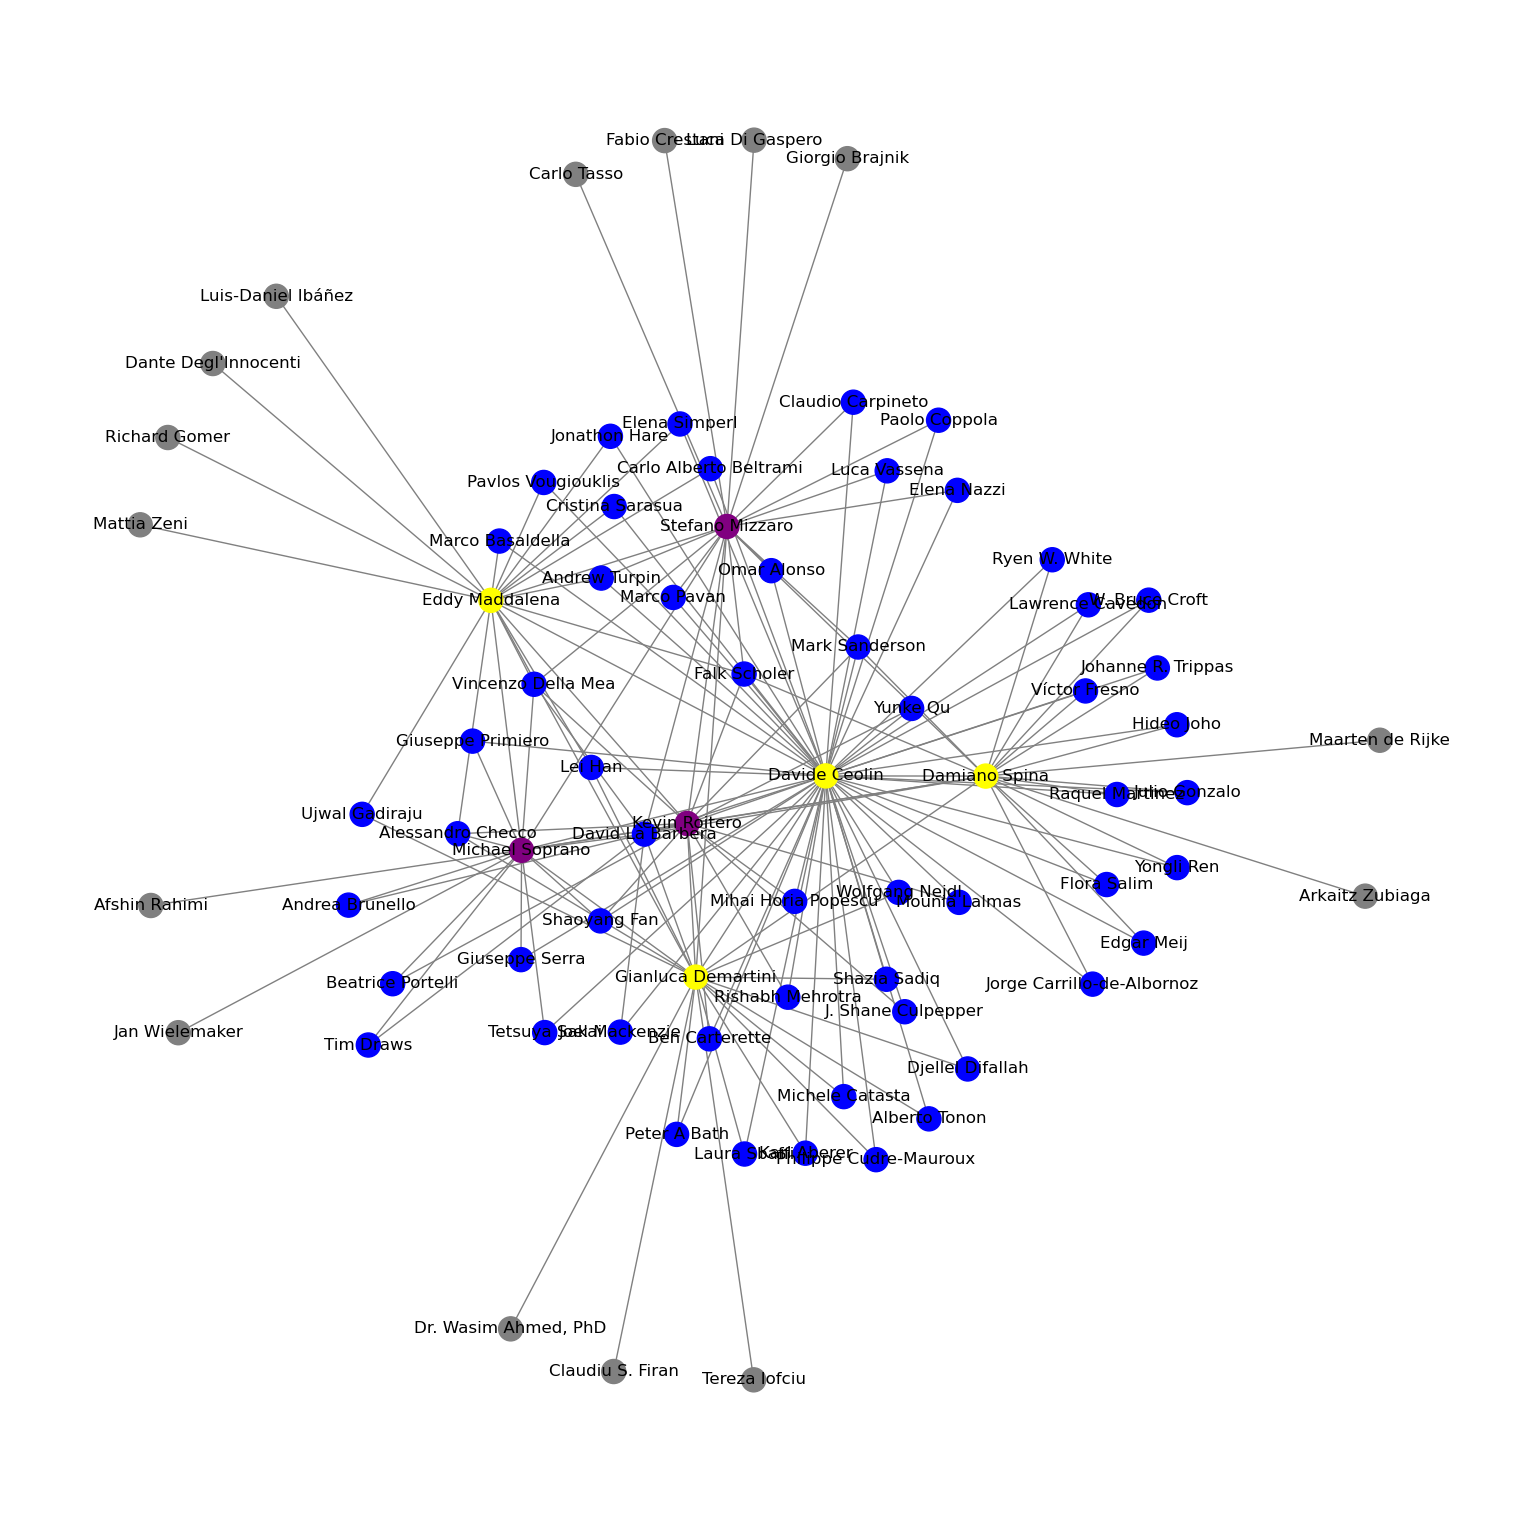

In [7]:
## 4.b

## print grafo
plt.figure(figsize=(15, 15))
nx.draw(extended_coautorship_graph,
        pos=nx.spring_layout(extended_coautorship_graph),
        node_color= Node_Color(extended_coautorship_graph),
        edge_color='grey',
        width=1,
        with_labels=True
        )

## save grafo 
plt.savefig("visualizations\\extended_graph.pdf")

plt.show()

5. Per entrambi i grafi prodotti calcolare:
    a. Coefficiente di clustering medio
    b. Centro del grafo
    c. Raggio
    d. Distanza Media
    e. Transitività
    f. Coefficienti Omega e Sigma, per stimare la “small-world-ness”
    g. Riassumere le informazioni in un DataFrame, dove ogni riga rappresenta le informazioni relative ad un grafo, ed ogni colonna le informazioni relative ad una misura calcolata per quel grafo. Salvare nella cartella /results tale DataFrame.


In [8]:
datiGrafo1 = {
    "nome" : "coautorship_graph",
    "clustering_medio": nx.average_clustering(coautorship_graph),
    "centro": ", ".join(nx.center(coautorship_graph)),              # conversione in stringa
    "raggio": nx.radius(coautorship_graph),
    "distanza_media": nx.average_shortest_path_length(coautorship_graph),
    "transitivita": nx.transitivity(coautorship_graph),
    "coeff_omega": nx.omega(coautorship_graph),
    "coeff_sigma": nx.sigma(coautorship_graph)
}

datiGrafo2 = {
    "nome" : "extended_coautorship_graph",
    "clustering_medio": nx.average_clustering(extended_coautorship_graph),
    "centro": ", ".join(nx.center(extended_coautorship_graph)),     # conversione in stringa
    "raggio": nx.radius(extended_coautorship_graph),
    "distanza_media": nx.average_shortest_path_length(extended_coautorship_graph),
    "transitivita": nx.transitivity(extended_coautorship_graph),
    "coeff_omega": nx.omega(extended_coautorship_graph),
    "coeff_sigma": nx.sigma(extended_coautorship_graph)
}

dataFrameGrafo1 = pd.DataFrame(datiGrafo1, index=[0])
dataFrameGrafo2 = pd.DataFrame(datiGrafo2, index=[0])
dfMisure = pd.concat([dataFrameGrafo1, dataFrameGrafo2])
dfMisure.to_csv("results\\overrall_measures.csv", index = False)

6. Per entrambi i grafi prodotti calcolare per ogni nodo:
a. Degree Centrality
b. Betweenness Centrality
c. Closeness Centrality
d. Pagerank
e. HITS, per calcolare i valori di hubness e authority
f. Riassumere le due informazioni in un DataFrame per ciascun grafo, dove ogni riga rappresenta le informazioni relative ad un nodo, ed ogni colonna le 
informazioni relative ad una misura calcolata per quel nodo. 
Salvare nella cartella /results tali DataFrame.

In [9]:
"""
    Questa funzione si occupa di calcolare l'indice degree centrality normalizzato sul grado massimo possibile
    PARAMETRI IN INGRESSO:
    dizionario formato in questo modo:
    { "nome e cognome della persona rappresentata nel nodo del grafo" : "degree centrality" , ...}
    OUTPUT:
    dizionario formato in questo modo:
    { "nome e cognome della persona rappresentata nel nodo del grafo" : "degree centrality normalizzato sul grado massimo possibile" , ...}
"""
def calcolo_degree_centrality_normalizzato_grado_massimo_possibile(dict_degree_centrality):
    #estrazione dei nomi e inserimento in una lista
    i=0
    names_list = []
    for node in dict_degree_centrality:
        names_list.insert(i,node)
        i=i+1
    j=0
    grandezza_grafo=coautorship_graph.number_of_nodes() 
    #calcolo dell'indice degree centrality normalizzato sul grado massimo possibile e inserimento in un dizionario dedicato
    degree_centrality_coautorship_normalizzato_grado_massimo_possibile={}
    for node in dict_degree_centrality:
        degree_centrality_coautorship_normalizzato_grado_massimo_possibile.update({
            names_list[j] : dict_degree_centrality[names_list[j]]/(grandezza_grafo-1)})
        j=j+1
    return degree_centrality_coautorship_normalizzato_grado_massimo_possibile


In [41]:
#calcolo degli indici in quest'ordine:
#1- degree centrality
#2- betweennes centrality
#3- closeness centrality
#4- pagerank
#5- HITS

degree_centrality_coautorship_graph=nx.degree_centrality(coautorship_graph)
degree_centrality_extended_coautorship_graph=nx.degree_centrality(extended_coautorship_graph)
print("Degree centrality 1- coautorship graph 2- extended coautorship graph")
print(degree_centrality_coautorship_graph)
print(degree_centrality_extended_coautorship_graph)
betweennes_centrality_coautorship_graph=nx.betweenness_centrality(coautorship_graph)
betweennes_centrality_extended_coautorship_graph=nx.betweenness_centrality(extended_coautorship_graph)
print("Betweennes centrality 1- coautorship graph 2- extended coautorship graph")
print(betweennes_centrality_coautorship_graph)
print(betweennes_centrality_extended_coautorship_graph)
closeness_centrality_coautorship_graph=nx.closeness_centrality(coautorship_graph)
closeness_centrality_extended_coautorship_graph=nx.closeness_centrality(extended_coautorship_graph)
print("Closeness centrality 1- coautorship graph 2- extended coautoship graph")
print(closeness_centrality_coautorship_graph)
print(closeness_centrality_extended_coautorship_graph)
page_rank_coautorship_graph=nx.pagerank(coautorship_graph)
page_rank_extended_coautorship_graph=nx.pagerank(extended_coautorship_graph)
print("Pagerank 1- coautorship graph 2- extended coautorship graph")
print(page_rank_coautorship_graph)
print(page_rank_extended_coautorship_graph)
hits_coautorship_graph=nx.hits(coautorship_graph)
hits_extended_coautorship_graph=nx.hits(extended_coautorship_graph)
#print("HITS 1- coautorship graph 2- extended coautorship graph")
#print(hits_coautorship_graph)
#print(hits_extended_coautorship_graph)

hubs_coautorship,authorities_coautorship=hits_coautorship_graph
hubs_extended_coautorship,authorities_extended_coautorship=hits_extended_coautorship_graph
print('HITS coautorship graph 1- hubs 2- authorities')
print(hubs_coautorship)
print(authorities_coautorship)
print('HITS extended coautorship graph 1- hubs 2- authorities')
print(hubs_extended_coautorship)
print(authorities_extended_coautorship)

#creazione dei dataframe
i=0
names_list = []
for node in degree_centrality_coautorship_graph:
    names_list.insert(i,node)
    i=i+1


#CREAZIONE DATAFRAME COAUTORSHIP GRAPH
i=0
dati_betweenness_centrality=[]
for node in betweennes_centrality_coautorship_graph:
    dati_betweenness_centrality.insert(i,betweennes_centrality_coautorship_graph[names_list[i]])
    i=i+1
#print('Betweenness')    
#print(betweennes_centrality_coautorship_graph)
#print(dati_betweenness_centrality)    

i=0
dati_closeness_centrality=[]
for node in closeness_centrality_coautorship_graph:
    dati_closeness_centrality.insert(i,closeness_centrality_coautorship_graph[names_list[i]])
    i=i+1

#print('Closeness')    
#print(closeness_centrality_coautorship_graph)
#print(dati_closeness_centrality)

i=0
dati_pagerank=[]
for node in page_rank_coautorship_graph:
    dati_pagerank.insert(i,page_rank_coautorship_graph[names_list[i]])
    i=i+1
#print('Page Rank')    
#print(page_rank_coautorship_graph)
#print(dati_pagerank)

i=0
dati_hits_hubs=[]
for node in hubs_coautorship:
    dati_hits_hubs.insert(i,hubs_coautorship[names_list[i]])
    i=i+1
#print('HITS hubs')    
#print(hubs_coautorship)
#print(dati_hits_hubs)

i=0
dati_hits_authorities=[]
for node in authorities_coautorship:
    dati_hits_authorities.insert(i,authorities_coautorship[names_list[i]])
    i=i+1
#print('HITS authorities')    
#print(authorities_coautorship)
#print(dati_hits_authorities)

i=0
dati_degree_centrality=[]
for node in degree_centrality_coautorship_graph:
    dati_degree_centrality.insert(i,degree_centrality_coautorship_graph[names_list[i]])
    i=i+1
#print('Degree')    
#print(degree_centrality_coautorship_graph)
#print(dati_degree_centrality)
#creo i dataframe
#nomi
names_dataframe=pd.DataFrame(data=names_list,columns=["Nodi del grafo"])

#degree centrality
degreecentralitydataframe=pd.DataFrame(data=dati_degree_centrality,columns=["Degree Centrality"])
#display(degreecentralitydataframe)

#betweenness centrality
betweennessdataframe=pd.DataFrame(data=dati_betweenness_centrality,columns=["Betweenness Centrality"])
#display(betweennessdataframe)

#closeness centrality
closenesssdataframe=pd.DataFrame(data=dati_closeness_centrality,columns=["Closeness Centrality"])
#display(closenesssdataframe)

#page rank
pagerankdataframe=pd.DataFrame(data=dati_pagerank,columns=["Page Rank"])
#display(pagerankdataframe)

#HITS hubs
hits_hubs_dataframe=pd.DataFrame(data=dati_hits_hubs,columns=["HITS Hubs"])
#display(hits_hubs_dataframe)

#HITS authority
hits_authorities_dataframe=pd.DataFrame(data=dati_hits_authorities,columns=["HITS Authorities"])
#display(hits_authorities_dataframe)

#primo test di merging
#df_unione = pd.merge(df1, df2, left_index=True, right_on=df1.index)

dataframeIndiciCoautorship=pd.merge(names_dataframe,degreecentralitydataframe,left_index=True,right_index=True)
dataframeIndiciCoautorship=pd.merge(dataframeIndiciCoautorship,betweennessdataframe,left_index=True,right_index=True)
dataframeIndiciCoautorship=pd.merge(dataframeIndiciCoautorship,closenesssdataframe,left_index=True,right_index=True)
dataframeIndiciCoautorship=pd.merge(dataframeIndiciCoautorship,pagerankdataframe,left_index=True,right_index=True)
dataframeIndiciCoautorship=pd.merge(dataframeIndiciCoautorship,hits_hubs_dataframe,left_index=True,right_index=True)
dataframeIndiciCoautorship=pd.merge(dataframeIndiciCoautorship,hits_authorities_dataframe,left_index=True,right_index=True)
#new_dataframe = pd.concat([testdataframe, betweennessdataframe])
#new_dataframe.rename(columns={'key_0' : 'Nodi'})
display(dataframeIndiciCoautorship)
print(dataframeIndiciCoautorship)










#CREAZIONE DATAFRAME EXTENDED COAUTHORSHIP GRAPH
i=0
dati_betweenness_centrality_extended=[]
for node in betweennes_centrality_extended_coautorship_graph:
    dati_betweenness_centrality_extended.insert(i,betweennes_centrality_extended_coautorship_graph[names_list[i]])
    i=i+1
print('Betweenness extended')    
print(betweennes_centrality_extended_coautorship_graph)
print(dati_betweenness_centrality_extended)    

i=0
dati_closeness_centrality_extended=[]
for node in closeness_centrality_extended_coautorship_graph:
    dati_closeness_centrality_extended.insert(i,closeness_centrality_extended_coautorship_graph[names_list[i]])
    i=i+1

print('Closeness extended')    
print(closeness_centrality_extended_coautorship_graph)
print(dati_closeness_centrality_extended)

i=0
dati_pagerank_extended=[]
for node in page_rank_extended_coautorship_graph:
    dati_pagerank_extended.insert(i,page_rank_extended_coautorship_graph[names_list[i]])
    i=i+1
print('Page Rank extended')    
print(page_rank_extended_coautorship_graph)
print(dati_pagerank_extended)

i=0
dati_hits_hubs_extended=[]
for node in hubs_extended_coautorship:
    dati_hits_hubs_extended.insert(i,hubs_extended_coautorship[names_list[i]])
    i=i+1
print('HITS hubs extended')    
print(hubs_extended_coautorship)
print(dati_hits_hubs_extended)

i=0
dati_hits_authorities_extended=[]
for node in authorities_extended_coautorship:
    dati_hits_authorities_extended.insert(i,authorities_extended_coautorship[names_list[i]])
    i=i+1
print('HITS authorities extended')    
print(authorities_extended_coautorship)
print(dati_hits_authorities_extended)

i=0
dati_degree_centrality_extended=[]
for node in degree_centrality_extended_coautorship_graph:
    dati_degree_centrality_extended.insert(i,degree_centrality_extended_coautorship_graph[names_list[i]])
    i=i+1
print('Degree centrality extended')    
print(degree_centrality_extended_coautorship_graph)
print(dati_degree_centrality_extended)
#creo i dataframe
#nomi
names_dataframe=pd.DataFrame(data=names_list,columns=["Nodi del grafo"])

#degree centrality
degreecentralitydataframe_extended=pd.DataFrame(data=dati_degree_centrality_extended,columns=["Degree Centrality Extended"])
display(degreecentralitydataframe_extended)

#betweenness centrality
betweennessdataframe_extended=pd.DataFrame(data=dati_betweenness_centrality_extended,columns=["Betweenness Centrality Extended"])
display(betweennessdataframe_extended)

#closeness centrality
closenesssdataframe_extended=pd.DataFrame(data=dati_closeness_centrality_extended,columns=["Closeness Centrality Extended"])
display(closenesssdataframe_extended)

#page rank
pagerankdataframe_extended=pd.DataFrame(data=dati_pagerank_extended,columns=["Page Rank Extended"])
display(pagerankdataframe_extended)

#HITS hubs
hits_hubs_dataframe_extended=pd.DataFrame(data=dati_hits_hubs_extended,columns=["HITS Hubs Extended"])
display(hits_hubs_dataframe_extended)

#HITS authority
hits_authorities_dataframe_extended=pd.DataFrame(data=dati_hits_authorities_extended,columns=["HITS Authorities Extended"])
display(hits_authorities_dataframe_extended)

#primo test di merging
#df_unione = pd.merge(df1, df2, left_index=True, right_on=df1.index)

dataframeIndiciCoautorship_extended=pd.merge(names_dataframe,degreecentralitydataframe_extended,left_index=True,right_index=True)
dataframeIndiciCoautorship_extended=pd.merge(dataframeIndiciCoautorship_extended,betweennessdataframe_extended,left_index=True,right_index=True)
dataframeIndiciCoautorship_extended=pd.merge(dataframeIndiciCoautorship_extended,closenesssdataframe_extended,left_index=True,right_index=True)
dataframeIndiciCoautorship_extended=pd.merge(dataframeIndiciCoautorship_extended,pagerankdataframe_extended,left_index=True,right_index=True)
dataframeIndiciCoautorship_extended=pd.merge(dataframeIndiciCoautorship_extended,hits_hubs_dataframe_extended,left_index=True,right_index=True)
dataframeIndiciCoautorship_extended=pd.merge(dataframeIndiciCoautorship_extended,hits_authorities_dataframe_extended,left_index=True,right_index=True)
#new_dataframe = pd.concat([testdataframe, betweennessdataframe])
#new_dataframe.rename(columns={'key_0' : 'Nodi'})
display(dataframeIndiciCoautorship_extended)
print(dataframeIndiciCoautorship_extended)


#creazione dei file
dataframeIndiciCoautorship.to_csv("results\\dataframeIndiciCoauthorship.csv", index = False)
dataframeIndiciCoautorship_extended.to_csv("results\\dataframeIndiciCoauthorshipExtended.csv", index = False)


Degree centrality 1- coautorship graph 2- extended coautorship graph
{'David La Barbera': 0.11842105263157894, 'Michael Soprano': 0.23684210526315788, 'Kevin Roitero': 0.2631578947368421, 'Stefano Mizzaro': 0.2631578947368421, 'Damiano Spina': 0.2763157894736842, 'Gianluca Demartini': 0.2763157894736842, 'Eddy Maddalena': 0.2763157894736842, 'Vincenzo Della Mea': 0.06578947368421052, 'Davide Ceolin': 0.05263157894736842, 'Tim Draws': 0.02631578947368421, 'Joel Mackenzie': 0.013157894736842105, 'Beatrice Portelli': 0.02631578947368421, 'Giuseppe Serra': 0.013157894736842105, 'Shaoyang Fan': 0.02631578947368421, 'Giuseppe Primiero': 0.013157894736842105, 'Jan Wielemaker': 0.013157894736842105, 'Alessandro Checco': 0.05263157894736842, 'Afshin Rahimi': 0.013157894736842105, 'Andrea Brunello': 0.02631578947368421, 'Tetsuya Sakai': 0.013157894736842105, 'Mihai Horia Popescu': 0.013157894736842105, 'Falk Scholer': 0.05263157894736842, 'J. Shane Culpepper': 0.013157894736842105, 'Yunke Qu': 0

,Nodi del grafo,Degree Centrality,Betweenness Centrality,Closeness Centrality,Page Rank,HITS Hubs,HITS Authorities
0,David La Barbera,0.118421,0.041589,0.496732,0.034056,0.043469,0.043469
1,Michael Soprano,0.236842,0.196113,0.567164,0.069596,0.060250,0.060250
2,Kevin Roitero,0.263158,0.216264,0.575758,0.077502,0.065121,0.065121
3,Stefano Mizzaro,0.263158,0.281644,0.575758,0.083657,0.058448,0.058448
4,Damiano Spina,0.276316,0.341322,0.539007,0.094931,0.048934,0.048934
...,...,...,...,...,...,...,...
72,Dante Degl'Innocenti,0.013158,0.000000,0.343891,0.005479,0.006484,0.006484
73,Pavlos Vougiouklis,0.013158,0.000000,0.343891,0.005479,0.006484,0.006484
74,Jonathon Hare,0.013158,0.000000,0.343891,0.005479,0.006484,0.006484
75,Carlo Alberto Beltrami,0.013158,0.000000,0.343891,0.005479,0.006484,0.006484


            Nodi del grafo  Degree Centrality  Betweenness Centrality  \
0         David La Barbera           0.118421                0.041589   
1          Michael Soprano           0.236842                0.196113   
2            Kevin Roitero           0.263158                0.216264   
3          Stefano Mizzaro           0.263158                0.281644   
4            Damiano Spina           0.276316                0.341322   
..                     ...                ...                     ...   
72    Dante Degl'Innocenti           0.013158                0.000000   
73      Pavlos Vougiouklis           0.013158                0.000000   
74           Jonathon Hare           0.013158                0.000000   
75  Carlo Alberto Beltrami           0.013158                0.000000   
76           Richard Gomer           0.013158                0.000000   

    Closeness Centrality  Page Rank  HITS Hubs  HITS Authorities  
0               0.496732   0.034056   0.043469          

,Degree Centrality Extended
0,0.118421
1,0.236842
2,0.263158
3,0.263158
4,0.289474
...,...
72,0.013158
73,0.026316
74,0.026316
75,0.026316


,Betweenness Centrality Extended
0,0.017359
1,0.116118
2,0.078832
3,0.141792
4,0.121400
...,...
72,0.000000
73,0.000000
74,0.000000
75,0.000000


,Closeness Centrality Extended
0,0.517007
1,0.567164
2,0.575758
3,0.575758
4,0.567164
...,...
72,0.365385
73,0.463415
74,0.463415
75,0.463415


,Page Rank Extended
0,0.024612
1,0.050968
2,0.054085
3,0.059117
4,0.063620
...,...
72,0.004477
73,0.006901
74,0.006901
75,0.006901


,HITS Hubs Extended
0,0.029061
1,0.038757
2,0.044009
3,0.035748
4,0.041446
...,...
72,0.003557
73,0.010431
74,0.010431
75,0.010431


,HITS Authorities Extended
0,0.029061
1,0.038757
2,0.044009
3,0.035748
4,0.041446
...,...
72,0.003557
73,0.010431
74,0.010431
75,0.010431


,Nodi del grafo,Degree Centrality Extended,Betweenness Centrality Extended,Closeness Centrality Extended,Page Rank Extended,HITS Hubs Extended,HITS Authorities Extended
0,David La Barbera,0.118421,0.017359,0.517007,0.024612,0.029061,0.029061
1,Michael Soprano,0.236842,0.116118,0.567164,0.050968,0.038757,0.038757
2,Kevin Roitero,0.263158,0.078832,0.575758,0.054085,0.044009,0.044009
3,Stefano Mizzaro,0.263158,0.141792,0.575758,0.059117,0.035748,0.035748
4,Damiano Spina,0.289474,0.121400,0.567164,0.063620,0.041446,0.041446
...,...,...,...,...,...,...,...
72,Dante Degl'Innocenti,0.013158,0.000000,0.365385,0.004477,0.003557,0.003557
73,Pavlos Vougiouklis,0.026316,0.000000,0.463415,0.006901,0.010431,0.010431
74,Jonathon Hare,0.026316,0.000000,0.463415,0.006901,0.010431,0.010431
75,Carlo Alberto Beltrami,0.026316,0.000000,0.463415,0.006901,0.010431,0.010431


            Nodi del grafo  Degree Centrality Extended  \
0         David La Barbera                    0.118421   
1          Michael Soprano                    0.236842   
2            Kevin Roitero                    0.263158   
3          Stefano Mizzaro                    0.263158   
4            Damiano Spina                    0.289474   
..                     ...                         ...   
72    Dante Degl'Innocenti                    0.013158   
73      Pavlos Vougiouklis                    0.026316   
74           Jonathon Hare                    0.026316   
75  Carlo Alberto Beltrami                    0.026316   
76           Richard Gomer                    0.013158   

    Betweenness Centrality Extended  Closeness Centrality Extended  \
0                          0.017359                       0.517007   
1                          0.116118                       0.567164   
2                          0.078832                       0.575758   
3                      

In [38]:
#FOGLIO CALCOLI



#print("inizio printing di non so cosa")
#print(coautorship_graph.number_of_nodes())
i=0
names_list = []
#print(degree_centrality_coautorship_graph)
#print(degree_centrality_coautorship_graph["David La Barbera"])
#estraggo solamente i nomi
for node in degree_centrality_coautorship_graph:
    names_list.insert(i,node)
    i=i+1

#print(names_list)  
i=0
values_list = []
#print("Piccolo test")
#print(degree_centrality_coautorship_graph[names_list[0]])
#estraggo solamente i valori come test
for node in degree_centrality_coautorship_graph:
    values_list.insert(i,degree_centrality_coautorship_graph[names_list[i]])
    i=i+1

#print(values_list)
#print(values_list[0])
j=0
grandezza_grafo=coautorship_graph.number_of_nodes()
#parte effettiva
degree_centrality_coautorship_graph_normalizzato_grado_massimo_possibile={}
for node in degree_centrality_coautorship_graph:
    degree_centrality_coautorship_graph_normalizzato_grado_massimo_possibile.update({names_list[j] : degree_centrality_coautorship_graph[names_list[j]]/(grandezza_grafo-1)})
    #names_list[j] : degree_centrality_coautorship_graph[names_list[j]]/(grandezza_grafo-1)
    j=j+1

#print(degree_centrality_coautorship_graph_normalizzato_grado_massimo_possibile)   
#print(names_list)
gradi = []
gradi=coautorship_graph.degree()
#print(gradi)
#print(gradi[0])
nomePerTest='David La Barbera'
gradoPerTest=gradi[nomePerTest]
#print(f'Nodo : {nomePerTest} Grado : {gradoPerTest}')
#print(gradoPerTest)
#calcolo dell'indice degree centrality normalizzato sul grado massimo effettivo
#estrazione dei gradi
#print(names_list)
i=0
GradoMassimo=0
for node in gradi:
    if gradi[names_list[i]] > GradoMassimo:
        GradoMassimo=gradi[names_list[i]]
        #print(f'prova : {GradoMassimo}')
    #print(f'indice : {i}')    
    i=i+1    
#print(f'Grado massimo : {GradoMassimo}')   


#idea per il dataframe:
#inserisco come indice i nomi presenti sui nodi e come dati faccio un ciclo in cui estraggo tutto il necessario (PRIMO DATAFRAME)
#per gli altri basta estrarre solo i valori e poi concateno tutto per creare un unico dataframe
#print(degree_centrality_coautorship_graph['David La Barbera'])


i=0
dati_degree_centrality=[]
for node in degree_centrality_coautorship_graph:
    dati_degree_centrality.insert(i,degree_centrality_coautorship_graph[names_list[i]])
    i=i+1
#print(dati_degree_centrality)
testdataframe=pd.DataFrame(data=dati_degree_centrality,index=names_list,columns=["Degree Centrality"])
#print(names_list)
#display(testdataframe)

#CREAZIONE DATAFRAME COAUTORSHIP GRAPH
i=0
dati_betweenness_centrality=[]
for node in betweennes_centrality_coautorship_graph:
    dati_betweenness_centrality.insert(i,betweennes_centrality_coautorship_graph[names_list[i]])
    i=i+1
#print('Betweenness')    
#print(betweennes_centrality_coautorship_graph)
#print(dati_betweenness_centrality)    

i=0
dati_closeness_centrality=[]
for node in closeness_centrality_coautorship_graph:
    dati_closeness_centrality.insert(i,closeness_centrality_coautorship_graph[names_list[i]])
    i=i+1

#print('Closeness')    
#print(closeness_centrality_coautorship_graph)
#print(dati_closeness_centrality)

i=0
dati_pagerank=[]
for node in page_rank_coautorship_graph:
    dati_pagerank.insert(i,page_rank_coautorship_graph[names_list[i]])
    i=i+1
#print('Page Rank')    
#print(page_rank_coautorship_graph)
#print(dati_pagerank)

i=0
dati_hits_hubs=[]
for node in hubs_coautorship:
    dati_hits_hubs.insert(i,hubs_coautorship[names_list[i]])
    i=i+1
#print('HITS hubs')    
#print(hubs_coautorship)
#print(dati_hits_hubs)

i=0
dati_hits_authorities=[]
for node in authorities_coautorship:
    dati_hits_authorities.insert(i,authorities_coautorship[names_list[i]])
    i=i+1
#print('HITS authorities')    
#print(authorities_coautorship)
#print(dati_hits_authorities)

i=0
dati_degree_centrality=[]
for node in degree_centrality_coautorship_graph:
    dati_degree_centrality.insert(i,degree_centrality_coautorship_graph[names_list[i]])
    i=i+1
#print('Degree')    
#print(degree_centrality_coautorship_graph)
#print(dati_degree_centrality)
#creo i dataframe
#nomi
names_dataframe=pd.DataFrame(data=names_list,columns=["Nodi del grafo"])

#degree centrality
degreecentralitydataframe=pd.DataFrame(data=dati_degree_centrality,columns=["Degree Centrality"])
#display(degreecentralitydataframe)

#betweenness centrality
betweennessdataframe=pd.DataFrame(data=dati_betweenness_centrality,columns=["Betweenness Centrality"])
#display(betweennessdataframe)

#closeness centrality
closenesssdataframe=pd.DataFrame(data=dati_closeness_centrality,columns=["Closeness Centrality"])
#display(closenesssdataframe)

#page rank
pagerankdataframe=pd.DataFrame(data=dati_pagerank,columns=["Page Rank"])
#display(pagerankdataframe)

#HITS hubs
hits_hubs_dataframe=pd.DataFrame(data=dati_hits_hubs,columns=["HITS Hubs"])
#display(hits_hubs_dataframe)

#HITS authority
hits_authorities_dataframe=pd.DataFrame(data=dati_hits_authorities,columns=["HITS Authorities"])
#display(hits_authorities_dataframe)

#primo test di merging
#df_unione = pd.merge(df1, df2, left_index=True, right_on=df1.index)

dataframeIndiciCoautorship=pd.merge(names_dataframe,degreecentralitydataframe,left_index=True,right_index=True)
dataframeIndiciCoautorship=pd.merge(dataframeIndiciCoautorship,betweennessdataframe,left_index=True,right_index=True)
dataframeIndiciCoautorship=pd.merge(dataframeIndiciCoautorship,closenesssdataframe,left_index=True,right_index=True)
dataframeIndiciCoautorship=pd.merge(dataframeIndiciCoautorship,pagerankdataframe,left_index=True,right_index=True)
dataframeIndiciCoautorship=pd.merge(dataframeIndiciCoautorship,hits_hubs_dataframe,left_index=True,right_index=True)
dataframeIndiciCoautorship=pd.merge(dataframeIndiciCoautorship,hits_authorities_dataframe,left_index=True,right_index=True)
#new_dataframe = pd.concat([testdataframe, betweennessdataframe])
#new_dataframe.rename(columns={'key_0' : 'Nodi'})
display(dataframeIndiciCoautorship)
print(dataframeIndiciCoautorship)










#CREAZIONE DATAFRAME EXTENDED COAUTHORSHIP GRAPH
i=0
dati_betweenness_centrality_extended=[]
for node in betweennes_centrality_extended_coautorship_graph:
    dati_betweenness_centrality_extended.insert(i,betweennes_centrality_extended_coautorship_graph[names_list[i]])
    i=i+1
print('Betweenness extended')    
print(betweennes_centrality_extended_coautorship_graph)
print(dati_betweenness_centrality_extended)    

i=0
dati_closeness_centrality_extended=[]
for node in closeness_centrality_extended_coautorship_graph:
    dati_closeness_centrality_extended.insert(i,closeness_centrality_extended_coautorship_graph[names_list[i]])
    i=i+1

print('Closeness extended')    
print(closeness_centrality_extended_coautorship_graph)
print(dati_closeness_centrality_extended)

i=0
dati_pagerank_extended=[]
for node in page_rank_extended_coautorship_graph:
    dati_pagerank_extended.insert(i,page_rank_extended_coautorship_graph[names_list[i]])
    i=i+1
print('Page Rank extended')    
print(page_rank_extended_coautorship_graph)
print(dati_pagerank_extended)

i=0
dati_hits_hubs_extended=[]
for node in hubs_extended_coautorship:
    dati_hits_hubs_extended.insert(i,hubs_extended_coautorship[names_list[i]])
    i=i+1
print('HITS hubs extended')    
print(hubs_extended_coautorship)
print(dati_hits_hubs_extended)

i=0
dati_hits_authorities_extended=[]
for node in authorities_extended_coautorship:
    dati_hits_authorities_extended.insert(i,authorities_extended_coautorship[names_list[i]])
    i=i+1
print('HITS authorities extended')    
print(authorities_extended_coautorship)
print(dati_hits_authorities_extended)

i=0
dati_degree_centrality_extended=[]
for node in degree_centrality_extended_coautorship_graph:
    dati_degree_centrality_extended.insert(i,degree_centrality_extended_coautorship_graph[names_list[i]])
    i=i+1
print('Degree centrality extended')    
print(degree_centrality_extended_coautorship_graph)
print(dati_degree_centrality_extended)
#creo i dataframe
#nomi
names_dataframe=pd.DataFrame(data=names_list,columns=["Nodi del grafo"])

#degree centrality
degreecentralitydataframe_extended=pd.DataFrame(data=dati_degree_centrality_extended,columns=["Degree Centrality Extended"])
display(degreecentralitydataframe_extended)

#betweenness centrality
betweennessdataframe_extended=pd.DataFrame(data=dati_betweenness_centrality_extended,columns=["Betweenness Centrality Extended"])
display(betweennessdataframe_extended)

#closeness centrality
closenesssdataframe_extended=pd.DataFrame(data=dati_closeness_centrality_extended,columns=["Closeness Centrality Extended"])
display(closenesssdataframe_extended)

#page rank
pagerankdataframe_extended=pd.DataFrame(data=dati_pagerank_extended,columns=["Page Rank Extended"])
display(pagerankdataframe_extended)

#HITS hubs
hits_hubs_dataframe_extended=pd.DataFrame(data=dati_hits_hubs_extended,columns=["HITS Hubs Extended"])
display(hits_hubs_dataframe_extended)

#HITS authority
hits_authorities_dataframe_extended=pd.DataFrame(data=dati_hits_authorities_extended,columns=["HITS Authorities Extended"])
display(hits_authorities_dataframe_extended)

#primo test di merging
#df_unione = pd.merge(df1, df2, left_index=True, right_on=df1.index)

dataframeIndiciCoautorship_extended=pd.merge(names_dataframe,degreecentralitydataframe_extended,left_index=True,right_index=True)
dataframeIndiciCoautorship_extended=pd.merge(dataframeIndiciCoautorship_extended,betweennessdataframe_extended,left_index=True,right_index=True)
dataframeIndiciCoautorship_extended=pd.merge(dataframeIndiciCoautorship_extended,closenesssdataframe_extended,left_index=True,right_index=True)
dataframeIndiciCoautorship_extended=pd.merge(dataframeIndiciCoautorship_extended,pagerankdataframe_extended,left_index=True,right_index=True)
dataframeIndiciCoautorship_extended=pd.merge(dataframeIndiciCoautorship_extended,hits_hubs_dataframe_extended,left_index=True,right_index=True)
dataframeIndiciCoautorship_extended=pd.merge(dataframeIndiciCoautorship_extended,hits_authorities_dataframe_extended,left_index=True,right_index=True)
#new_dataframe = pd.concat([testdataframe, betweennessdataframe])
#new_dataframe.rename(columns={'key_0' : 'Nodi'})
display(dataframeIndiciCoautorship_extended)
print(dataframeIndiciCoautorship_extended)

,Nodi del grafo,Degree Centrality,Betweenness Centrality,Closeness Centrality,Page Rank,HITS Hubs,HITS Authorities
0,David La Barbera,0.118421,0.041589,0.496732,0.034056,0.043469,0.043469
1,Michael Soprano,0.236842,0.196113,0.567164,0.069596,0.060250,0.060250
2,Kevin Roitero,0.263158,0.216264,0.575758,0.077502,0.065121,0.065121
3,Stefano Mizzaro,0.263158,0.281644,0.575758,0.083657,0.058448,0.058448
4,Damiano Spina,0.276316,0.341322,0.539007,0.094931,0.048934,0.048934
...,...,...,...,...,...,...,...
72,Dante Degl'Innocenti,0.013158,0.000000,0.343891,0.005479,0.006484,0.006484
73,Pavlos Vougiouklis,0.013158,0.000000,0.343891,0.005479,0.006484,0.006484
74,Jonathon Hare,0.013158,0.000000,0.343891,0.005479,0.006484,0.006484
75,Carlo Alberto Beltrami,0.013158,0.000000,0.343891,0.005479,0.006484,0.006484


            Nodi del grafo  Degree Centrality  Betweenness Centrality  \
0         David La Barbera           0.118421                0.041589   
1          Michael Soprano           0.236842                0.196113   
2            Kevin Roitero           0.263158                0.216264   
3          Stefano Mizzaro           0.263158                0.281644   
4            Damiano Spina           0.276316                0.341322   
..                     ...                ...                     ...   
72    Dante Degl'Innocenti           0.013158                0.000000   
73      Pavlos Vougiouklis           0.013158                0.000000   
74           Jonathon Hare           0.013158                0.000000   
75  Carlo Alberto Beltrami           0.013158                0.000000   
76           Richard Gomer           0.013158                0.000000   

    Closeness Centrality  Page Rank  HITS Hubs  HITS Authorities  
0               0.496732   0.034056   0.043469          

,Degree Centrality Extended
0,0.118421
1,0.236842
2,0.263158
3,0.263158
4,0.289474
...,...
72,0.013158
73,0.026316
74,0.026316
75,0.026316


,Betweenness Centrality Extended
0,0.017359
1,0.116118
2,0.078832
3,0.141792
4,0.121400
...,...
72,0.000000
73,0.000000
74,0.000000
75,0.000000


,Closeness Centrality Extended
0,0.517007
1,0.567164
2,0.575758
3,0.575758
4,0.567164
...,...
72,0.365385
73,0.463415
74,0.463415
75,0.463415


,Page Rank Extended
0,0.024612
1,0.050968
2,0.054085
3,0.059117
4,0.063620
...,...
72,0.004477
73,0.006901
74,0.006901
75,0.006901


,HITS Hubs Extended
0,0.029061
1,0.038757
2,0.044009
3,0.035748
4,0.041446
...,...
72,0.003557
73,0.010431
74,0.010431
75,0.010431


,HITS Authorities Extended
0,0.029061
1,0.038757
2,0.044009
3,0.035748
4,0.041446
...,...
72,0.003557
73,0.010431
74,0.010431
75,0.010431


,Nodi del grafo,Degree Centrality Extended,Betweenness Centrality Extended,Closeness Centrality Extended,Page Rank Extended,HITS Hubs Extended,HITS Authorities Extended
0,David La Barbera,0.118421,0.017359,0.517007,0.024612,0.029061,0.029061
1,Michael Soprano,0.236842,0.116118,0.567164,0.050968,0.038757,0.038757
2,Kevin Roitero,0.263158,0.078832,0.575758,0.054085,0.044009,0.044009
3,Stefano Mizzaro,0.263158,0.141792,0.575758,0.059117,0.035748,0.035748
4,Damiano Spina,0.289474,0.121400,0.567164,0.063620,0.041446,0.041446
...,...,...,...,...,...,...,...
72,Dante Degl'Innocenti,0.013158,0.000000,0.365385,0.004477,0.003557,0.003557
73,Pavlos Vougiouklis,0.026316,0.000000,0.463415,0.006901,0.010431,0.010431
74,Jonathon Hare,0.026316,0.000000,0.463415,0.006901,0.010431,0.010431
75,Carlo Alberto Beltrami,0.026316,0.000000,0.463415,0.006901,0.010431,0.010431


            Nodi del grafo  Degree Centrality Extended  \
0         David La Barbera                    0.118421   
1          Michael Soprano                    0.236842   
2            Kevin Roitero                    0.263158   
3          Stefano Mizzaro                    0.263158   
4            Damiano Spina                    0.289474   
..                     ...                         ...   
72    Dante Degl'Innocenti                    0.013158   
73      Pavlos Vougiouklis                    0.026316   
74           Jonathon Hare                    0.026316   
75  Carlo Alberto Beltrami                    0.026316   
76           Richard Gomer                    0.013158   

    Betweenness Centrality Extended  Closeness Centrality Extended  \
0                          0.017359                       0.517007   
1                          0.116118                       0.567164   
2                          0.078832                       0.575758   
3                      

7. Produrre una visualizzazione interattiva con PyVis dei due grafi con colorazioni di
nodi ed archi a piacimento. Salvare i due output in formato HTML nella cartella
/visualizations.

In [12]:
## Save grafo interattivo

nt= pv.network.Network(height= '600px', 
                       width='100%')


for node, color in zip(coautorship_graph.nodes(), Node_Color(coautorship_graph)):
    nt.add_node(node, label=str(node), color=color)

nt.from_nx(coautorship_graph)
nt.save_graph('visualizations\\interactive_first_graph.html')


nt= pv.network.Network(height= '600px', 
                       width='100%')

for node, color in zip(extended_coautorship_graph.nodes(), Node_Color(extended_coautorship_graph)):
    nt.add_node(node, label=str(node), color=color)

nt.from_nx(extended_coautorship_graph)
nt.save_graph('visualizations\\interactive_extended_graph.html')